## Import library

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.api import Holt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import math
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings('ignore')

## Data loading

In [18]:
df1 = pd.read_csv('../data_engineering/historik_antam.csv')
df2 = pd.read_csv('../data_engineering/HargaEmas_clean_latest.csv')

In [19]:
df1

,Unnamed: 0,datetime,price,year,month,day
0,0,2010-01-04 09:07:00,408000,2010,1,4
1,1,2010-01-05 09:28:00,410000,2010,1,5
2,2,2010-01-06 07:01:00,410000,2010,1,6
3,3,2010-01-07 09:45:00,412000,2010,1,7
4,4,2010-01-08 09:37:00,410000,2010,1,8
...,...,...,...,...,...,...
4086,4086,2023-10-04 08:00:33,1040000,2023,10,4
4087,4087,2023-10-05 08:00:05,1043000,2023,10,5
4088,4088,2023-10-06 08:13:24,1043000,2023,10,6
4089,4089,2023-10-07 08:27:44,1047000,2023,10,7


In [20]:
df2

,datetime,price,year,month,day
0,2023-10-11 08:18:25,1063000,2023,10,11


In [21]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4091 entries, 0 to 4090
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  4091 non-null   int64 
 1   datetime    4091 non-null   object
 2   price       4091 non-null   int64 
 3   year        4091 non-null   int64 
 4   month       4091 non-null   int64 
 5   day         4091 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 191.9+ KB


In [22]:
df1.drop(columns='Unnamed: 0', inplace=True)

In [25]:
df1

,datetime,price,year,month,day
0,2010-01-04 09:07:00,408000,2010,1,4
1,2010-01-05 09:28:00,410000,2010,1,5
2,2010-01-06 07:01:00,410000,2010,1,6
3,2010-01-07 09:45:00,412000,2010,1,7
4,2010-01-08 09:37:00,410000,2010,1,8
...,...,...,...,...,...
4086,2023-10-04 08:00:33,1040000,2023,10,4
4087,2023-10-05 08:00:05,1043000,2023,10,5
4088,2023-10-06 08:13:24,1043000,2023,10,6
4089,2023-10-07 08:27:44,1047000,2023,10,7


In [23]:
df1['datetime'] = pd.to_datetime(df1['datetime'])

In [26]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4091 entries, 0 to 4090
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  4091 non-null   datetime64[ns]
 1   price     4091 non-null   int64         
 2   year      4091 non-null   int64         
 3   month     4091 non-null   int64         
 4   day       4091 non-null   int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 159.9 KB


In [ ]:
#df1['datetime'] = pd.DatetimeIndex(df1['datetime']).date

In [27]:
df1

,datetime,price,year,month,day
0,2010-01-04 09:07:00,408000,2010,1,4
1,2010-01-05 09:28:00,410000,2010,1,5
2,2010-01-06 07:01:00,410000,2010,1,6
3,2010-01-07 09:45:00,412000,2010,1,7
4,2010-01-08 09:37:00,410000,2010,1,8
...,...,...,...,...,...
4086,2023-10-04 08:00:33,1040000,2023,10,4
4087,2023-10-05 08:00:05,1043000,2023,10,5
4088,2023-10-06 08:13:24,1043000,2023,10,6
4089,2023-10-07 08:27:44,1047000,2023,10,7


## Data splitting

In [28]:
train = df1[0:round(len(df1)-365)][['datetime','price']]
test = df1[round(len(df1)-365):][['datetime','price']]

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3726 entries, 0 to 3725
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  3726 non-null   datetime64[ns]
 1   price     3726 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 58.3 KB


In [29]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 3726 to 4090
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  365 non-null    datetime64[ns]
 1   price     365 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.8 KB


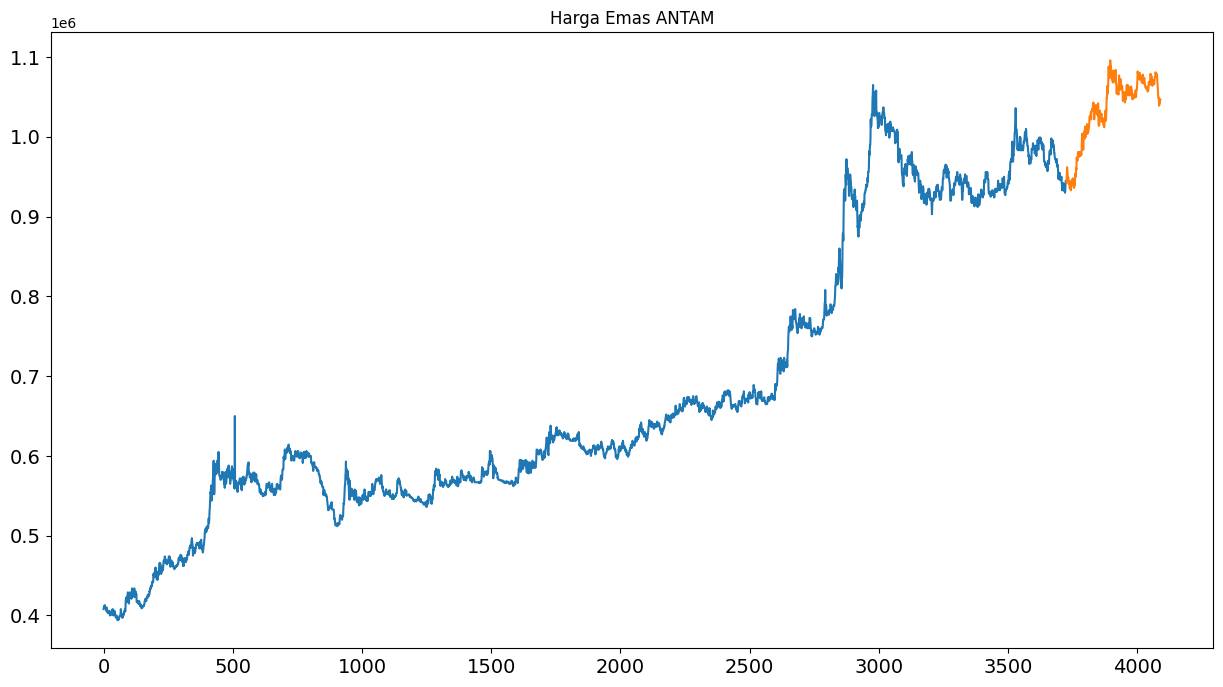

In [30]:
train['datetime'] = pd.DatetimeIndex(train['datetime']).date
test['datetime'] = pd.DatetimeIndex(test['datetime']).date

#df1['price'].plot(figsize=(15,8), title= 'Harga Emas ANTAM', fontsize=14)
train['price'].plot(figsize=(15,8), title= 'Harga Emas ANTAM', fontsize=14)
test['price'].plot(figsize=(15,8), title= 'Harga Emas ANTAM', fontsize=14)

plt.show()

In [31]:
def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [ ]:
check_stationarity(train['price'])

ADF Statistic: -0.682328
p-value: 0.851274
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Non-stationary


Data tidak stasioner. Maka, either pake Holt-Winters atau Holt Linear Trend.

<Axes: xlabel='datetime'>

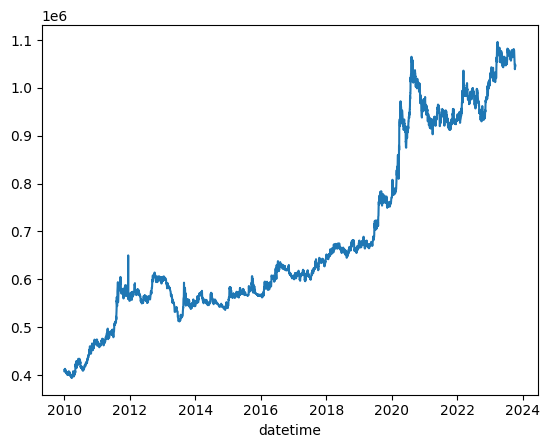

In [ ]:
df1.set_index('datetime', inplace=True)
df1['price'].plot()

In [ ]:
df1

,price,year,month,day
datetime,,,,
2010-01-04,408000,2010,1,4
2010-01-05,410000,2010,1,5
2010-01-06,410000,2010,1,6
2010-01-07,412000,2010,1,7
2010-01-08,410000,2010,1,8
...,...,...,...,...
2023-10-04,1040000,2023,10,4
2023-10-05,1043000,2023,10,5
2023-10-06,1043000,2023,10,6


additive


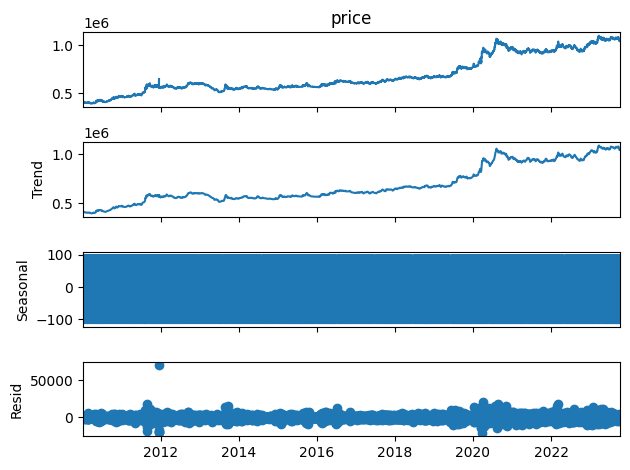

additive


In [ ]:
print('additive')
res = seasonal_decompose(df1['price'], model='additive', period=5)
ax=res.plot()
plt.show()
print('additive')

multiplicative


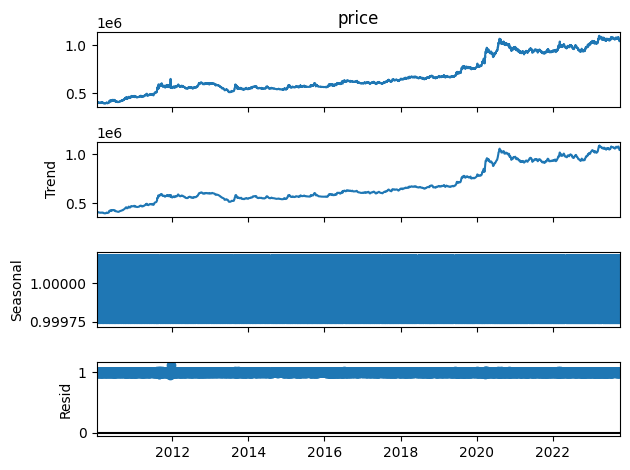

multiplicative


In [ ]:
print('multiplicative')
res = seasonal_decompose(df1['price'], model='multiplicative', period=5)
ax=res.plot()
plt.show()
print('multiplicative')

Dari kedua visualisasi tidak terlihat seasonal-nya, maka akan dicoba menggunakan Holt's Linear Trend.

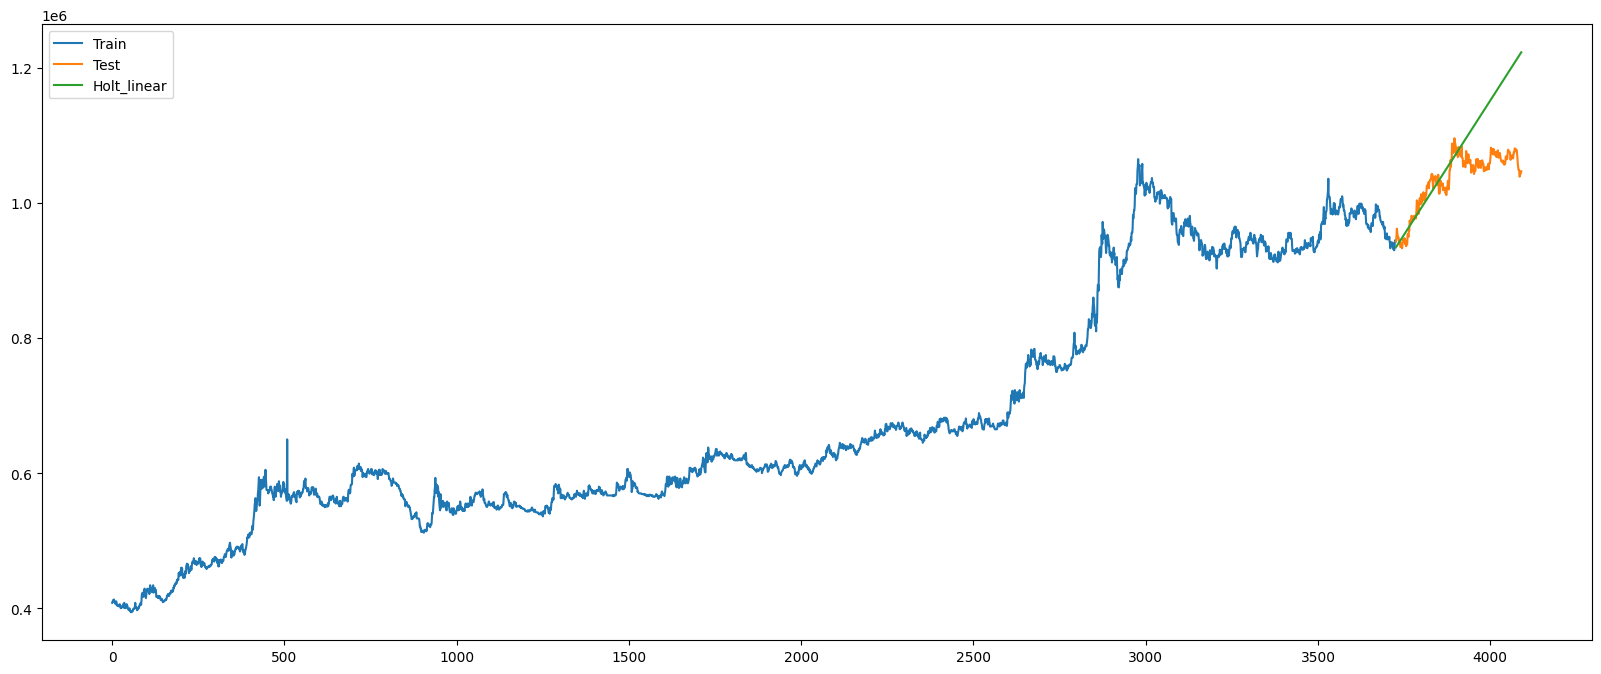

mae : 50322.62464858792
rmse : 69555.08505152704


In [ ]:
y_hat_avg = test.copy()
y_hat_avg['datetime'] = pd.DatetimeIndex(y_hat_avg['datetime']).date
fit1 = Holt(np.asarray(train['price'])).fit(smoothing_level = 0.1,smoothing_slope = 0.5)
y_hat_avg['Holt_linear'] = fit1.forecast(len(test))
plt.figure(figsize=(20,8))
plt.plot(train['price'], label='Train')
plt.plot(test['price'], label='Test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()

print("mae :", mean_absolute_error(test['price'], y_hat_avg.Holt_linear))
print("rmse :", math.sqrt(mean_squared_error(test['price'], y_hat_avg.Holt_linear)))

Hasil prediksinya tidak bagus. Akan dicoba metode lain.

## Differencing

1st order differencing
ADF Statistic: -20.226062
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Stationary


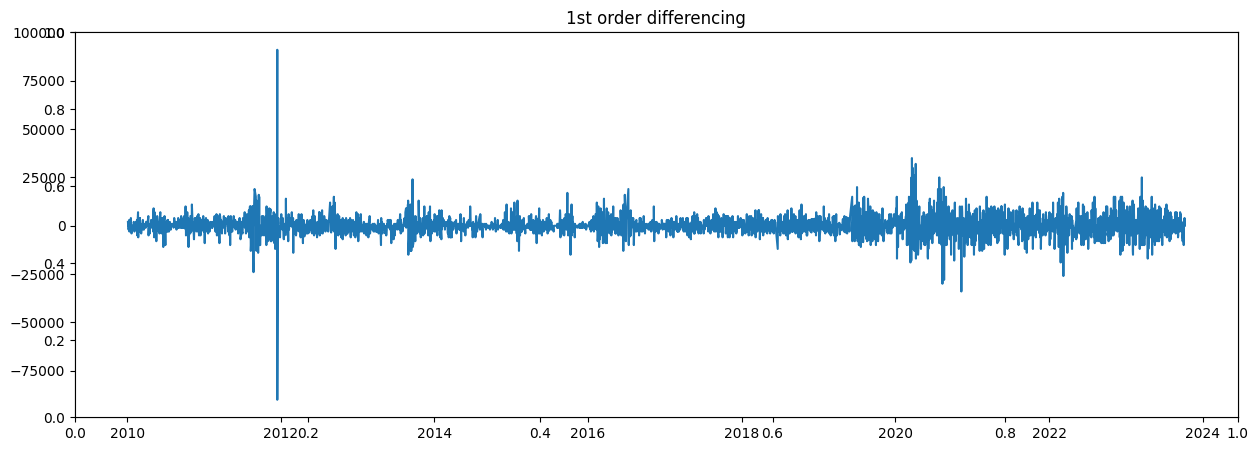

In [ ]:
diff1 = df1['price'].diff()
# Plot the result after first-order differencing

fig, ax = plt.subplots(figsize=(15,5))
ax1 = fig.add_subplot(111)
ax1.set_title('1st order differencing')
ax1.plot(diff1)

# Check stationarity after performing first-order differencing

print("1st order differencing")
check_stationarity(diff1.dropna())

Sudah stasioner dengan differencing orde pertama.

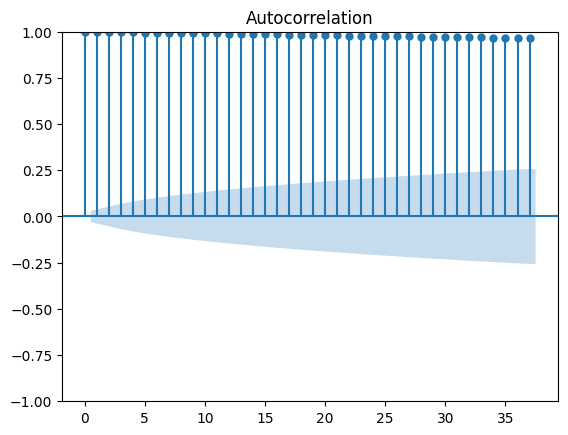

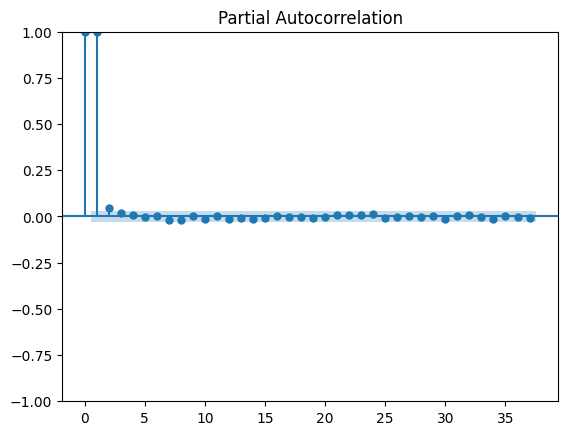

In [ ]:
# Plot ACF & PACF from the original dataset

plot_acf(df1['price'])
plot_pacf(df1['price'])
plt.show()

In [ ]:
diff1

datetime
2010-01-04       NaN
2010-01-05    2000.0
2010-01-06       0.0
2010-01-07    2000.0
2010-01-08   -2000.0
               ...  
2023-10-04    1000.0
2023-10-05    3000.0
2023-10-06       0.0
2023-10-07    4000.0
2023-10-08       0.0
Name: price, Length: 4091, dtype: float64

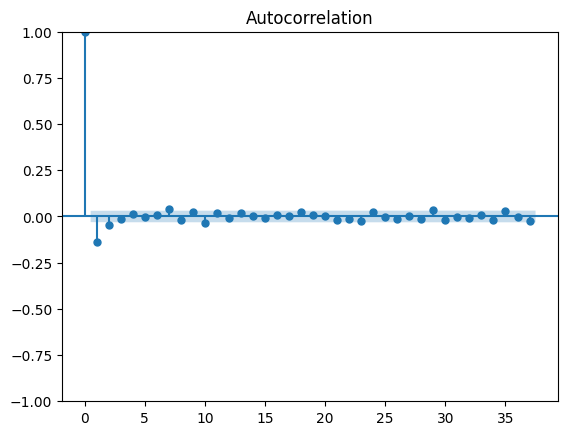

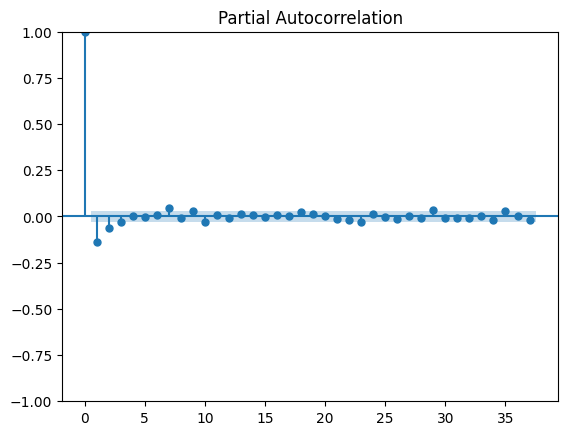

In [ ]:
# Plot ACF & PACF from the first-order differenced dataset

plot_acf(df1['price'].diff().dropna())
plot_pacf(df1['price'].diff().dropna())
plt.show()

Untuk data yang sudah di-differencing 1 kali, ACF cut off: (1, 2, 7), PACF cut off: (1, 2, 7)

In [33]:
# Create a function to find best model

def find_best_model(data, num_p, num_d, num_q):
  df = pd.DataFrame() #We make a pandas dataframe to ease our work, you can use any way that makes you comfortable and work easly
  pdq = [[],[],[]] #This list for storing the combinations of p and q
  aic = [] # This list for storing aic value
  for p in range(num_p + 1): #plus one is to make the range up to num_p since python range only ranging from 0 to N-1
    for d in range(num_d + 1):
      for q in range(num_q + 1):
        # #if p!=0 and q!=0: #this logic will avoid (0,0) value which is not correct
        try: #Using exception to avoid the error while training the model with certain p and q value
          model = ARIMA(data, order=(p, d, q))
          result = model.fit()
          pdq[0].append(p)
          pdq[1].append(d)
          pdq[2].append(q)
          aic.append(result.aic)
        except:
          pass #If there is an error caused by the calculation, it will be skipped to the next iteration

  df['p'] = pdq[0]
  df['d'] = pdq[1]
  df['q'] = pdq[2]
  df['AIC'] = aic

  df.sort_values('AIC', inplace=True)

  return df.p.iloc[0], df.d.iloc[0], df.q.iloc[0], df.AIC.iloc[0], df

In [34]:
%%time

# Find best model of ARIMA with combinations of p=7, d=1, q=20

find_best_model(df1['price'], 7, 1, 20)

In [ ]:
# make the model
price_predictor = ARIMA(train['price'], order=(1,0,2))
result_predictor = price_predictor.fit()

In [ ]:
y_hat_avg

,datetime,price,Holt_linear
3726,2022-10-02,943000,9.342444e+05
3727,2022-10-03,945000,9.350384e+05
3728,2022-10-04,955000,9.358323e+05
3729,2022-10-05,962000,9.366262e+05
3730,2022-10-06,957000,9.374201e+05
...,...,...,...
4086,2023-10-04,1040000,1.220051e+06
4087,2023-10-05,1043000,1.220845e+06
4088,2023-10-06,1043000,1.221639e+06
4089,2023-10-07,1047000,1.222433e+06


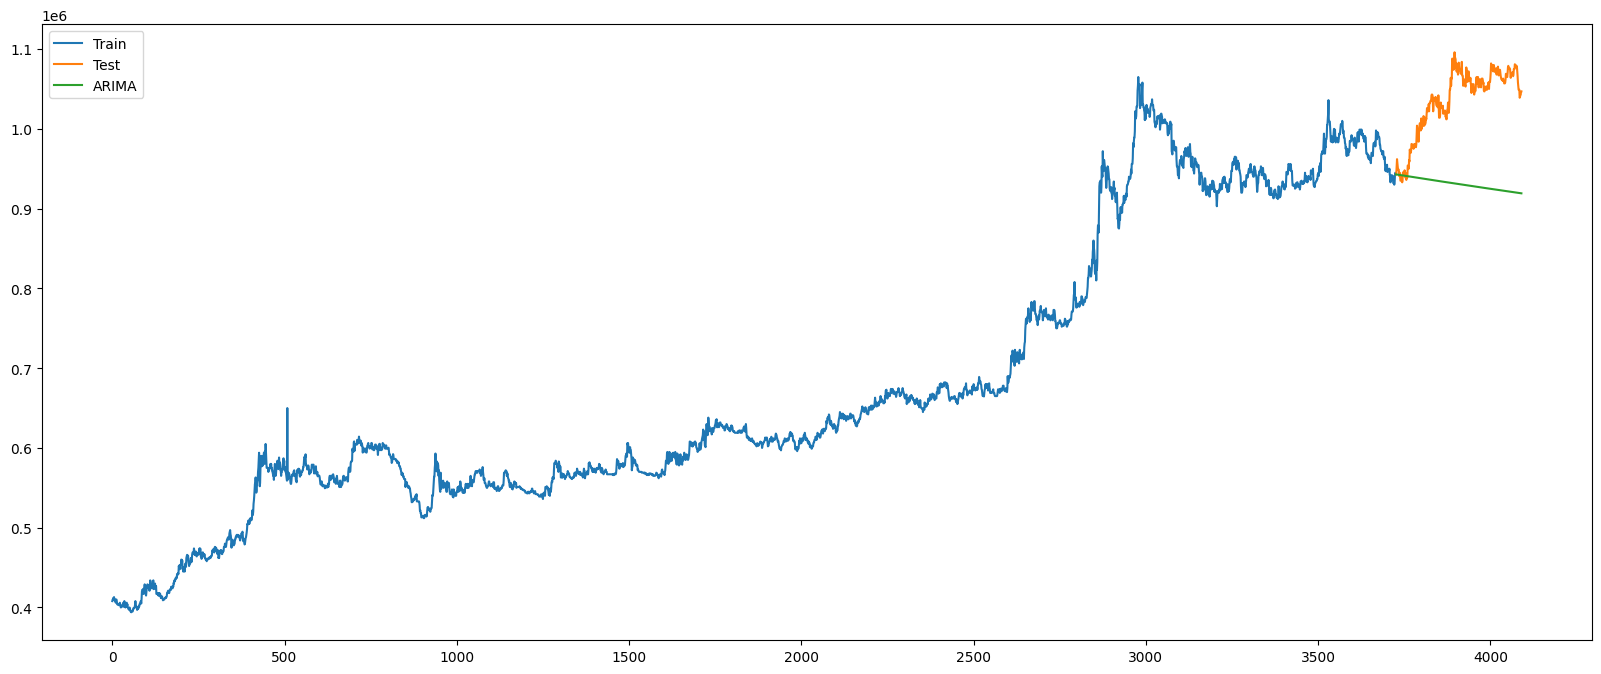

mae : 104723.56007204555
rmse : 114855.22763057445


In [ ]:
y_hat_avg['ARIMA'] = result_predictor.forecast(len(test))
plt.figure(figsize=(20,8))
plt.plot(train['price'], label='Train')
plt.plot(test['price'], label='Test')
plt.plot(y_hat_avg['ARIMA'], label='ARIMA')
plt.legend(loc='best')
plt.show()

print("mae :", mean_absolute_error(test['price'], y_hat_avg['ARIMA']))
print("rmse :", math.sqrt(mean_squared_error(test['price'], y_hat_avg['ARIMA'])))

In [ ]:
test.tails()

NameError: name 'test' is not defined

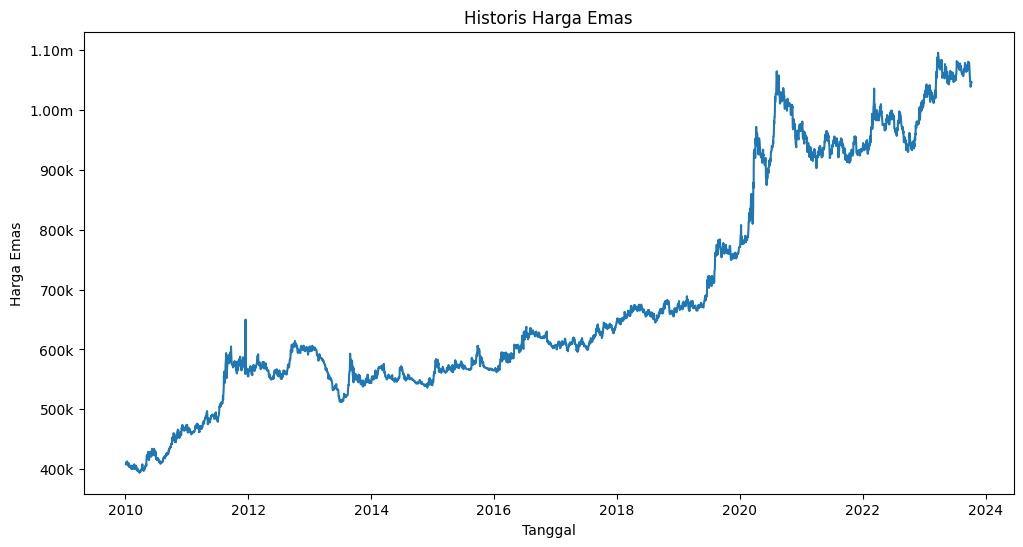

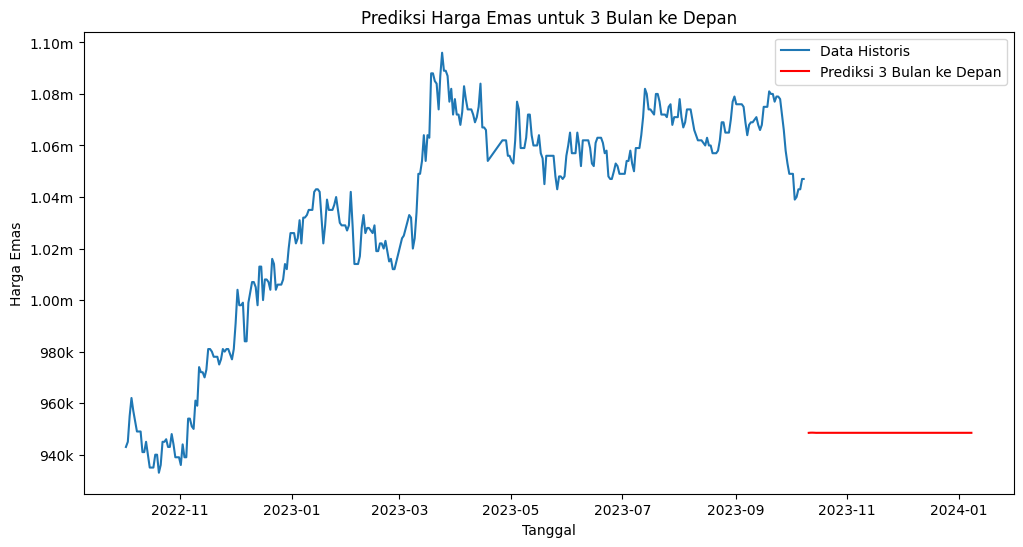

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from statsmodels.tsa.arima.model import ARIMA
import datetime

def price_formatter(x, pos):
    if x >= 1e6:
        return f'{x/1e6:.2f}m'
    elif x >= 1e3:
        return f'{int(x/1e3)}k'
    else:
        return str(int(x))

# Load data
data = pd.read_csv('../data_engineering/historik_antam.csv')
timestamps = pd.to_datetime(data['datetime'])
prices = data['price']

# Visualisasi data
plt.figure(figsize=(12, 6))
plt.plot(timestamps, prices)
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(price_formatter))
plt.title('Historis Harga Emas')
plt.xlabel('Tanggal')
plt.ylabel('Harga Emas')
plt.show()

# Tanggal hari ini
today = datetime.date.today()

# Pemisahan data
train_size = int(len(data) * 0.8)
train_data = prices[:train_size]

# Pelatihan model ARIMA
model = ARIMA(train_data, order=(5, 1, 0))
model_fit = model.fit()

# Prediksi 3 bulan ke depan
forecast = model_fit.forecast(steps=90)

# Buat indeks tanggal untuk data prediksi
forecast_index = pd.date_range(start=today, periods=90, freq='D')

# Visualisasi hasil prediksi
plt.figure(figsize=(12, 6))
plt.plot(timestamps[4091-365:], prices[4091-365:], label='Data Historis')
plt.plot(forecast_index, forecast, color='red', label='Prediksi 3 Bulan ke Depan')
plt.title('Prediksi Harga Emas untuk 3 Bulan ke Depan')
plt.xlabel('Tanggal')
plt.ylabel('Harga Emas')
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(price_formatter))
plt.legend()
plt.show()